### Seq2Seq +Attention 메커니즘을 활용

---



In [ ]:
import pandas as pd
import numpy as np
import random
import re
import os
import warnings
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Embedding, Dense, Masking, Layer, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
%matplotlib inline
warnings.filterwarnings('ignore')       # 성가신 경고는 출력하지 않고 무시

#### 1. 데이터를 읽어와서 전처리 한다.

In [ ]:
# 구글 드라이브 마운트
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# my_data = pd.read_csv('AI_chatbot(4th_prj)/data/source_target.csv', on_bad_lines='skip')
my_data = pd.read_csv('AI_chatbot(4th_prj)/data/preprocessed_qna_1(hs).csv', on_bad_lines='skip')

In [ ]:
my_data.sample(10)                    # 랜덤으로 10 행 보여주기

,questions,answers
1686,아차산닭한마리에 인접한 시설을 알 수 있나요?,"아차산닭한마리에 인접한 시설에는 광나루역 1번 출구, 광장초등학교, 미도빌라가 ..."
20329,아잇의 주차시설이 있나요?,아잇의 주차시설이 있습니다
14969,보드람치킨 개화산점의 주차시설이 있나요?,보드람치킨 개화산점의 주차시설이 없습니다
16991,장사랑 디큐브시티점의 휴무일은 어떻게 되나요?,장사랑 디큐브시티점의 휴무일은 알수없음입니다
12407,신마라본색 본점의 연락처가 어떻게 되나요?,신마라본색 본점의 연락처는 010-5871-8388입니다
12536,연어이야기에 인접한 시설이 있나요?,"연어이야기에 인접한 시설에는 고려대역 4번 출구, 홍파초등학교, 이에나파이가 있습니다"
17614,카페 사우스야라의 영업시간은 어떻게 되나요?,카페 사우스야라의 영업시간은 11:00 ~ 20:00입니다
2338,따우전드의 주차시설이 있는지 알 수 있나요?,따우전드의 주차시설이 없습니다
13974,곱창하우스에 인접한 시설이 있나요?,"곱창하우스에 인접한 시설에는 군자역 8번 출구, 손수제치킨, 한솥도시락가 있습니다"
19570,해바라기정육식당 신길점의 주차시설이 있는지 알 수 있나요?,해바라기정육식당 신길점의 주차시설이 있습니다


In [ ]:
# 기본적인 전처리
my_data['questions'] = my_data['questions'].str.replace('\W',' ',regex=True)      # 특수 문자 공백으로 대체
my_data['questions'] = my_data['questions'].str.replace('\s+',' ',regex=True)     # 잉여 공백 제거

my_data['answers'] = my_data['answers'].str.replace('\W',' ',regex=True)      # 특수 문자 공백으로 대체
my_data['answers'] = my_data['answers'].str.replace('\s+',' ',regex=True)     # 잉여 공백 제거

In [ ]:
# 단어 단위로 토큰화 하고, decoder 입력과 출력에 필요한 Target에는 <sos>태그와 <eos> 태그를 붙여준다
my_src_in = []
my_tar_in = []
my_tar_out = []
for i in range(len(my_data)):
    a_src = my_data.questions.loc[i].split()           # Encoder에 입력되는 Source는 있는 그대로 split해 둘 수 있다
    a_tar = my_data.answers.loc[i]
    a_tar_in = [a_word for a_word in ('<sos> ' + a_tar).split()]
    a_tar_out = [a_word for a_word in (a_tar + ' <eos>').split()]
    my_src_in.append(a_src)
    my_tar_in.append(a_tar_in)
    my_tar_out.append(a_tar_out)

In [ ]:
# 전처리 이후 출력
print(my_src_in[10:20])
print(my_tar_in[10:20])
print(my_tar_out[10:20])

[['숙이네닭발의', '연락처를', '알', '수', '있나요?'], ['숙이네닭발에', '인접한', '시설이', '있나요?'], ['술김생의', '주소는', '어떻게', '되나요?'], ['술김생의', '연락처를', '알', '수', '있나요?'], ['술김생의', '주차시설이', '있나요?'], ['술김생에', '인접한', '시설을', '알', '수', '있나요?'], ['술김생의', '대표적인', '메뉴를', '알', '수', '있나요?'], ['술김생의', '휴무일은', '어떻게', '되나요?'], ['술김생의', '휴무일을', '알', '수', '있나요?'], ['술김생의', '주소를', '알', '수', '있나요?']]
[['<sos>', '숙이네닭발의', '연락처는', '02-798-0838입니다'], ['<sos>', '숙이네닭발에', '인접한', '시설에는', '이태원역', '3번', '출구,', '보광초등학교가', '있습니다'], ['<sos>', '술김생의', '주소는', '서울', '광진구', '아차산로', '238입니다'], ['<sos>', '술김생의', '연락처는', '0507-1363-7833입니다'], ['<sos>', '술김생의', '주차시설이', '있습니다'], ['<sos>', '술김생에', '인접한', '시설에는', '건대입구역', '5번', '출구,', '베리폴댄스,', '감자탕사돈가', '있습니다'], ['<sos>', '술김생의', '메뉴에는', '김치생삼겹살,', '목살이', '있습니다'], ['<sos>', '술김생의', '휴무일은', '매주', '일요일입니다'], ['<sos>', '술김생의', '휴무일은', '매주', '일요일입니다'], ['<sos>', '술김생의', '주소는', '서울', '광진구', '아차산로', '238입니다']]
[['숙이네닭발의', '연락처는', '02-798-0838입니다', '<eos>'], ['숙이네닭발에', '인접한', '시설에는', '이태원역', '3번', '출구,', '보광

In [ ]:
# 정수 인코딩 Source
my_tokenizer_src = Tokenizer()
my_tokenizer_src.fit_on_texts(my_src_in)
my_encoder_in = my_tokenizer_src.texts_to_sequences(my_src_in)

# 정수 인코딩 Target. In과 Out 별도
my_tokenizer_tar = Tokenizer()
my_tokenizer_tar.fit_on_texts(my_tar_in)         # 학습
my_tokenizer_tar.fit_on_texts(my_tar_out)        # 추가 학습
my_decoder_in = my_tokenizer_tar.texts_to_sequences(my_tar_in)
my_decoder_out = my_tokenizer_tar.texts_to_sequences(my_tar_out)

In [ ]:
# 패딩. 가장 긴 문장에 맞추어진다
my_encoder_in_pad = pad_sequences(my_encoder_in, padding='post')
my_decoder_in_pad = pad_sequences(my_decoder_in, padding='post')
my_decoder_out_pad = pad_sequences(my_decoder_out, padding='post')

In [ ]:
# 다음과 같이 tar_in에만 들어있는 '<sos>'와 '<eos>'가 제대로 학습되었음을 확인
print( my_tokenizer_tar.word_index['<sos>'] )
print( my_tokenizer_tar.word_index['<eos>'] )

1
2


In [ ]:
# Vocabulary 크기
SRC_VOCAB_SIZE = len(my_tokenizer_src.word_index) + 1     # 0이 패딩용으로 추가되어 +1
TAR_VOCAB_SIZE = len(my_tokenizer_tar.word_index) + 1     # 0이 패딩용으로 추가되어 +1
print('Source vocabulary size : {:d}, Target vocabulary size : {:d}'.format(SRC_VOCAB_SIZE, TAR_VOCAB_SIZE))

Source vocabulary size : 3813, Target vocabulary size : 15424


In [ ]:
# 변환 사전
src_to_index = my_tokenizer_src.word_index
index_to_src = my_tokenizer_src.index_word

tar_to_index = my_tokenizer_tar.word_index
index_to_tar = my_tokenizer_tar.index_word

In [ ]:
# 데이터를 섞어 놓는다
# 데이터 쪼개기 준비
idx = list(range(len(my_data)))
random.shuffle(idx)
my_encoder_in_pad = my_encoder_in_pad[idx]
my_decoder_in_pad = my_decoder_in_pad[idx]
my_decoder_out_pad = my_decoder_out_pad[idx]

In [ ]:
# Train-Test split
n_train = int(len(my_data)*0.8)
n_test = len(my_data) - n_train
my_encoder_in_train = my_encoder_in_pad[:n_train]
my_decoder_in_train = my_decoder_in_pad[:n_train]
my_decoder_out_train = my_decoder_out_pad[:n_train]

my_encoder_in_test = my_encoder_in_pad[-n_train:]
my_decoder_in_test = my_decoder_in_pad[-n_train:]
my_decoder_out_test = my_decoder_out_pad[-n_train:]

#### 2. Seq2Seq 모델링

In [ ]:
N_EMBEDDING = 20                   # Embedding 차원의 크기 정의.
N_HIDDEN = 32                     # 은닉 차원의 수.

In [ ]:
# 인코더 Layer 정의
# 부모 클래스 Layer를 상속받아서 정의

# 향후 저장과 로딩이 용이하도록 데코레이터 적용
@register_keras_serializable()
class Encoder(Layer):

# 층 구조 정의
  def __init__(self, vocab_size, n_embedding, n_hidden):
    super(Encoder, self).__init__()                                   # 부모 클래스의 생성자 함수 호출.
    self.vocab_size = vocab_size
    self.n_embedding = n_embedding
    self.n_hidden = n_hidden
    self.embedding = Embedding(self.vocab_size, self.n_embedding)     # Embedding 층. 정수 1개씩 입력 전제
    self.masking = Masking(mask_value=0.0)                            # 패딩 0은 연산에서 제외. 해당 스텝은 스킵
    self.lstm = LSTM(units = self.n_hidden, return_sequences=True, return_state=True)    # Attention을 위해서 return_sequences=True로 설정

# 객체가 호출될때 실제 사용되는 함수
  def call(self, x):
    x = self.embedding(x)
    x = self.masking(x)
    encoder_outputs, state_h, state_c = self.lstm(x)                 # Attention을 위해 encoder_outputs를 받아둔다
    return encoder_outputs, [state_h, state_c]                       # Attention을 위해 모든 것 반환

In [ ]:
# 디코더 Layer 정의
# 부모 클래스 Layer를 상속받아서 정의

# 향후 저장과 로딩이 용이하도록 데코레이터 적용
@register_keras_serializable()
class Decoder(Layer):

# 층 구조를 정의한다.
  def __init__(self, vocab_size, n_embedding, n_hidden):
    super(Decoder, self).__init__()                                   # 부모 클래스의 생성자 함수 호출
    self.vocab_size = vocab_size
    self.n_embedding = n_embedding
    self.n_hidden = n_hidden
    self.embedding = Embedding(self.vocab_size, self.n_embedding)     # Embedding 층. 정수 1개씩 입력 전제
    self.masking = Masking(mask_value=0.0)                            # 패딩 0은 연산에서 제외. 해당 스텝은 스킵
    self.lstm = LSTM(units=self.n_hidden, return_sequences=True, return_state=True) # 상태값 리턴을 위해 return_state=True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences=True
    self.attention = Attention(score_mode='dot')                      # score_mode는 'dot'나 'concat'이 될 수 있다
    self.dense = Dense(units=self.vocab_size, activation='softmax')   # 모든 시점의 결과에 대해서 소프트맥스 함수를 적용하는 출력층을 통해 단어 예측

# 객체가 호출될때 실제 사용되는 함수
  def call(self, x, prev_states, encoder_outputs):                    # Attention을 위해 encoder_outputs 필요
    x = self.embedding(x)
    x = self.masking(x)
    decoder_outputs, _, _ = self.lstm(x, initial_state=prev_states)        # initial_state에 주목한다. 출력된 state_h, state_c는 그대로 버린다
    attention_vector = self.attention([decoder_outputs, encoder_outputs])  # Attention vector를 만든다
    x = self.dense(tf.concat([attention_vector,decoder_outputs],axis=2))   # Attention vector와 결합해 context_vector를 만들어 넣는다
    return x

In [ ]:
# Seq2Seq 정의
# 부모 클래스 Model를 상속받아서 정의된다

# 향후 저장과 로딩이 용이하도록 데코레이터 적용
@register_keras_serializable()
class Seq2Seq(Model):
  def __init__(self, src_vocab_size, tar_vocab_size, n_embedding, n_hidden):
    super(Seq2Seq, self).__init__()                                   # 부모 클래스의 생성자 함수 호출
    self.encoder = Encoder(src_vocab_size, n_embedding, n_hidden)     # 인코더 객체 생성
    self.decoder = Decoder(tar_vocab_size, n_embedding, n_hidden)     # 디코더 객체 생성

  def call(self, x):
    encoder_inputs, decoder_inputs = x                               # 입력을 세분화 한다
    encoder_outputs, encoder_states = self.encoder(encoder_inputs)   # 인코더의 최종 상태를 만든다
    decoder_outputs = self.decoder(decoder_inputs, encoder_states, encoder_outputs)  # Attention을 위해 encoder_outputs도 받는다
    return decoder_outputs

  # 디코더 한 스텝씩 예측 처리해 주는 함수
  def predict_one_step(self, encoder_inputs, decoder_input, decoder_initial_states=None):
    encoder_outputs, encoder_states = self.encoder(encoder_inputs)    # Attention을 위해 항시 계산
    if not decoder_initial_states:                                    # decoder_initial_states가 입력되지 않았다면, 첫 번째 스텝
      decoder_initial_states = encoder_states                         # 인코더의 최종 상태가 바로 디코더의 초기 상태
    x = self.decoder.embedding(decoder_input)
    x = self.decoder.masking(x)
    decoder_outputs, state_h, state_c = self.decoder.lstm(x, initial_state=decoder_initial_states)
    attention_vector = self.decoder.attention([decoder_outputs, encoder_outputs])  # Attention vector를 만든다
    decoder_probs = self.decoder.dense(tf.concat([attention_vector,decoder_outputs],axis=2))  # 인덱스별 확률!
    return decoder_probs, state_h, state_c

In [ ]:
# Seq2Seq 모델 객체 생성
my_model = Seq2Seq(SRC_VOCAB_SIZE, TAR_VOCAB_SIZE, N_EMBEDDING, N_HIDDEN)

#### 3. 모델 컴파일과 학습

In [ ]:
# 하이퍼 파라미터 설정
n_epochs = 100                    # Number of epochs
batch_size = 32                  # Size of each batch
learn_rate = 0.005               # Learning rate

In [ ]:
# 모델 컴파일
my_optimizer=Adam(learning_rate=learn_rate)
my_model.compile(optimizer=my_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [86]:
# Train
callback1 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)                      # 조기 종료 허락!
callback2 = ModelCheckpoint(filepath='./models/seq2seq_02.h5',monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True)  # 최적 모델 저장
my_summary = my_model.fit(x = [my_encoder_in_train, my_decoder_in_train], y = my_decoder_out_train, validation_data = ([my_encoder_in_test, my_decoder_in_test], my_decoder_out_test), batch_size = batch_size, epochs = n_epochs, callbacks=[callback1, callback2], verbose=1)

Epoch 26: early stopping


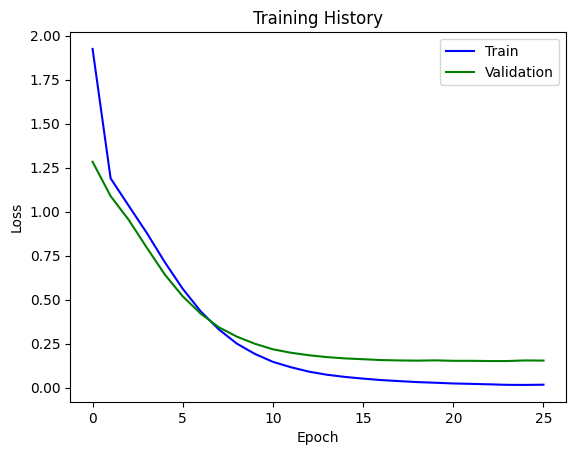

In [ ]:
# 학습 history 출력
plt.plot(my_summary.history['loss'], c='b')
plt.plot(my_summary.history['val_loss'], c='g')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

#### 4. 모델 테스트

In [ ]:
# 학습된 모델을 로딩한다
# my_model.built = True
# my_model.load_weights('./models/seq2seq_02.h5')

In [ ]:
# 디코더를 사용해서 예측해 주는 헬퍼 함수.
MAX_SEQUENCE = 100                       # 문장의 최대 길이
def decode_sequence(input_seq):

    # <sos>에 해당하는 정수 생성. 디코더의 시작점을 의미한다
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 스텝 한개씩 반복한다. batch_size = 1로 설정해서 단순화
    # 인코더의 최종 상태를 디코더의 초기 상태로 받겠다는 의미
    initial_states = None
    while not stop_condition:
        # <sos>와 이전 시점의 상태 initial_states를 현 시점의 초기 상태로 사용
        probs, h, c = my_model.predict_one_step(input_seq, target_seq, initial_states)

        # 현 스텝에서 출력된 상태를 다음 스텝의 입력으로 사용하기 위해서 저장
        initial_states = [h, c]

        # 예측 결과를 단어로 변환
        # 유일한 타임 스텝의 (확률) 출력 벡터에서 argmax로 해당 인덱스를 가져온다
        pred_index = np.argmax(probs[0, -1, :])

        # 인덱스를 단어로 변환해 준다
        pred_word = index_to_tar[pred_index]

        # <eos>에 도달 또는 최대 길이 초과시 중단
        if (pred_word == '<eos>' or len(decoded_sentence) >= MAX_SEQUENCE):
          stop_condition = True
          continue

        # 예측된 단어를 결과 문장에 이어 붙인다
        decoded_sentence += ' ' + pred_word

        # 현 스텝의 예측을 다음 스텝의 입력으로 사용하기 위해서 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = pred_index

    return decoded_sentence

In [ ]:
# 정수 시퀀스를 Source 문장으로 변환해 주는 핼퍼 함수
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i] + ' '
    return temp

# 정수 시퀀스를 Target 문장으로 변환해 주는 헬퍼 함수
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

In [ ]:
# 학습용 데이터를 다시 사용해서 예측 테스트
for i in [random.randint(0,n_train-1) for _ in range(5)]:
    input_seq = my_encoder_in_train[i: i + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('Input sentence     :',seq2src(my_encoder_in_train[i]))
    print('Correct sentence   :',seq2tar(my_decoder_in_train[i]))
    print('Machine translated :',decoded_sentence)
    print('\n')

Input sentence     : 향기고을의 대표적인 메뉴를 알 수 있나요? 
Correct sentence   : 향기고을의 메뉴에는 청국장, 제육떡볶이2인이 있습니다 
Machine translated :  향기고을의 메뉴에는 청국장, 제육떡볶이2인이 있습니다


Input sentence     : 선식당의 주소는 어떻게 되나요? 
Correct sentence   : 선식당의 주소는 서울 영등포구 선유로 33 문래대림아파트101동 1층상가입니다 
Machine translated :  선식당의 주소는 서울 영등포구 선유로 33 문래대림아파트101동 1층상가입니다


Input sentence     : 놀부부대찌개 불광역점에 인접한 시설을 알 수 있나요? 
Correct sentence   : 놀부부대찌개 불광역점에 인접한 시설에는 불광역 8번출구, 불광역 9번출구, 강너머남촌 숯불닭갈비, 디저트39 불광점가 있습니다 
Machine translated :  놀부부대찌개 불광역점에 인접한 시설에는 불광역 8번출구, 불광역 9번출구, 강너머남촌 숯불닭갈비, 디저트39 불광점가 있습니다


Input sentence     : 오니기리와이규동 군자역점의 영업시간은 어떻게 되나요? 
Correct sentence   : 오니기리와이규동 군자역점의 영업시간은 09:30/10:00-21:30입니다 
Machine translated :  오니기리와이규동 군자역점의 영업시간은 09:30/10:00-21:30입니다


Input sentence     : 크로네베이커리의 주소를 알 수 있나요? 
Correct sentence   : 크로네베이커리의 주소는 서울 동대문구 경희대로 17입니다 
Machine translated :  크로네베이커리의 주소는 서울 동대문구 경희대로 17입니다




In [ ]:
# 별도의 시험용 데이터를 사용해서 예측 테스트
for i in [random.randint(0,n_test-1) for _ in range(5)]:
    input_seq = my_encoder_in_test[i: i + 1]
    decoded_sentence = decode_sequence(input_seq)

    print('Input sentence     :',seq2src(my_encoder_in_test[i]))
    print('Correct sentence   :',seq2tar(my_decoder_in_test[i]))
    print('Machine translated :',decoded_sentence)
    print('\n')

Input sentence     : 중문닭갈비의 연락처가 어떻게 되나요? 
Correct sentence   : 중문닭갈비의 연락처는 알수없음입니다 
Machine translated :  중문닭갈비의 연락처는 알수없음입니다


Input sentence     : 털보네순대국의 대표 메뉴가 무엇인가요? 
Correct sentence   : 털보네순대국의 메뉴에는 순대국, 뼈해장국이 있습니다 
Machine translated :  털보네순대국의 메뉴에는 순대국, 뼈해장국이 있습니다


Input sentence     : 현덕육회의 대표적인 메뉴는 무엇이 있나요? 
Correct sentence   : 현덕육회의 메뉴에는 숙성육회, 숙성육물회이 있습니다 
Machine translated :  현덕육회의 메뉴에는 숙성육회, 숙성육물회이 있습니다


Input sentence     : 권영수대가전골의 영업시간을 알 수 있나요? 
Correct sentence   : 권영수대가전골의 영업시간은 09:00 - 21:00입니다 
Machine translated :  권영수대가전골의 영업시간은 09:00 - 21:00입니다


Input sentence     : 생생아구에 인접한 시설을 알 수 있나요? 
Correct sentence   : 생생아구에 인접한 시설에는 종합운동장역 9번 출구, 르제니스, 시큐에버가 있습니다 
Machine translated :  생생아구에 인접한 시설에는 종합운동장역 9번 출구, 르제니스, 시큐에버가 있습니다




In [ ]:
# 임의의 질문에 응답해 본다
q = input('Question: ')
encoded = []
for a_word in q.lower().split():
   if a_word in src_to_index:
     encoded.append(src_to_index[a_word])
encoded = np.array([encoded])
print( decode_sequence(encoded))